In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# dest_standard = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/denoised/Standard_plane'

# std_img_files = [f for f in os.listdir(dest_standard) if f.endswith(".png")]
# print(len(std_img_files))

In [ ]:
# dest_non_standard = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/denoised/Non-standard_plane'

# non_std_img_files = [f for f in os.listdir(dest_non_standard) if f.endswith(".png")]
# print(len(non_std_img_files))

ResNet Model

In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.identity_downsample = identity_downsample
        # print("identity:::",self.identity_downsample)

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return nn.functional.softmax(x, dim=1)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # print("stride: ",stride)
        # print("in_channels: ",self.in_channels)
        # print("intermediate_channels: ",intermediate_channels)

        if stride != 1 or self.in_channels != intermediate_channels:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels)
            )
            # print("identity_downsample: ",identity_downsample)

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

def ResNet18():
    img_channel = 3
    num_classes = 2
    return ResNet(Block, [2, 2, 2, 2], img_channel, num_classes)

resnet18 = ResNet18()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3)

Early Stopping

In [ ]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

Save and Load Checkpoint

In [ ]:
def save_checkpoint_f(model, optimizer, path, epoch, fold, train_acc, val_acc, early_stopping,train_accuracies,val_accuracies,train_f1_scores,
                    val_f1_scores,train_roc_aucs,val_roc_aucs,all_train_loss,all_val_loss,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
                    fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss):
    checkpoint = {
        'fold': fold,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'val_acc': val_acc,
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_f1_scores':train_f1_scores,
        'val_f1_scores':val_f1_scores,
        'train_roc_aucs':train_roc_aucs,
        'val_roc_aucs':val_roc_aucs,
        'all_train_loss':all_train_loss,
        'all_val_loss':all_val_loss,
        'best_acc':best_acc,
        'fold_train_accuracies':fold_train_accuracies,
        'fold_val_accuracies':fold_val_accuracies,
        'fold_train_loss':fold_train_loss,
        'fold_val_loss':fold_val_loss,
        'fold_train_f1':fold_train_f1,
        'fold_val_f1':fold_val_f1,
        'fold_train_roc':fold_train_roc,
        'fold_val_roc':fold_val_roc,
        'track_all_train_loss':track_all_train_loss,
        'track_all_val_loss':track_all_val_loss
    }
    torch.save(checkpoint, path)



def load_checkpoint_f(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']
    best_loss = checkpoint.get('best_loss', None)
    counter = checkpoint.get('counter', 0)
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    all_train_loss = checkpoint.get('all_train_loss', [])
    all_val_loss = checkpoint.get('all_val_loss',[])
    train_f1_scores = checkpoint.get('train_f1_scores', [])
    val_f1_scores = checkpoint.get('val_f1_scores', [])
    train_roc_aucs = checkpoint.get('train_roc_aucs', [])
    val_roc_aucs = checkpoint.get('val_roc_aucs', [])
    best_acc = checkpoint['best_acc']
    fold_train_accuracies = checkpoint.get('fold_train_accuracies', [])
    fold_val_accuracies = checkpoint.get('fold_val_accuracies', [])
    fold_train_loss = checkpoint.get('fold_train_loss', [])
    fold_val_loss = checkpoint.get('fold_val_loss', [])
    fold_train_f1 = checkpoint.get('fold_train_f1', [])
    fold_val_f1 = checkpoint.get('fold_val_f1', [])
    fold_train_roc = checkpoint.get('fold_train_roc', [])
    fold_val_roc = checkpoint.get('fold_val_roc', [])
    track_all_train_loss = checkpoint.get('track_all_train_loss', [])
    track_all_val_loss = checkpoint.get('track_all_val_loss', [])


    return (model, optimizer, epoch, train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,
            train_f1_scores,val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
            fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss)


def load_checkpoint_fold(path):
    checkpoint = torch.load(path)
    fold = checkpoint['fold']
    return fold

Dataset Load

In [ ]:
class UltrasoundDataset_f(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to load image paths and labels from class folders
def load_dataset_f(root_dir):
    image_paths = []
    labels = []

    for class_label, class_name in enumerate(['Non-standard_plane','Standard_plane']):
        class_dir = os.path.join(root_dir, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_label)

    return image_paths, labels

# Load dataset from folders
root_dir = '/content/drive/MyDrive/thesis/dataset_6302024/2.Thesis_12k'
image_paths, labels = load_dataset_f(root_dir)


# Step 1: Split into 4/6 for training, and 2/6 for validation + testing
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=1/6, stratify=labels, random_state=42
)


def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function early in the script
set_seed(42)

# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create Dataset objects
# train_dataset_f = UltrasoundDataset_f(train_image_paths, train_labels, transform=train_transform)
test_dataset_f = UltrasoundDataset_f(test_image_paths, test_labels, transform=test_transform)

# print(len(train_dataset_f))
print(len(test_dataset_f))

2097


In [ ]:
from collections import Counter

# Count the occurrences of each class in the test dataset
class_counts = Counter(test_labels)

# Print the class distribution
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")

Class 1: 1517 images
Class 0: 580 images


Load training dataset and then split them into train and validation dataset

In [ ]:
root_dir = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/denoised'
image_paths, labels = load_dataset_f(root_dir)

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function early in the script
set_seed(42)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_f = UltrasoundDataset_f(image_paths, labels, transform=train_transform)
print(len(train_dataset_f))

15168


Training and Evaluation

In [ ]:
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# import random
# from sklearn.model_selection import StratifiedKFold

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# net = resnet18.to(device)



# save_dir = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/Plain_RESNET18/DENOISED_FULL_PSFHSP_12k/fold_model'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir,exist_ok=True)


# checkpoint_dir = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/Plain_RESNET18/DENOISED_FULL_PSFHSP_12k/fold_model_checkpoints_resnet18'
# if not os.path.exists(checkpoint_dir):
#     os.makedirs(checkpoint_dir,exist_ok=True)

# best_model_path = os.path.join(save_dir, f'best_model.pth')

# # Check if any checkpoint file exists in the directory
# checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

# # Set load_model to True if any checkpoint file exists, otherwise False
# load_model = True if checkpoint_files else False



# if load_model:
#     print("Loading fold...")
#     fold = load_checkpoint_fold(os.path.join(checkpoint_dir, f'checkpoint_epoch.pth'))
#     print("fold: ",fold+1)
#     fold += 1
# else:
#     print("No fold to load.")


# print("Training and evaluation")



# skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)


# model = net.to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# num_epochs = 200
# train_loss = []
# validation_loss = []

# patience = 20
# early_stopping = EarlyStopping(patience=patience)
# early_stop = False

# if load_model:
#     print("Loading model...")
#     (model, optimizer, start_epoch, train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,train_f1_scores,
#      val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
#      fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss) = load_checkpoint_f(model, optimizer, os.path.join(checkpoint_dir, f'checkpoint_epoch.pth'))

#     early_stopping.best_loss = best_loss
#     early_stopping.counter = counter
#     best_model_wts = model.state_dict()

#     if (start_epoch+1)% 5 == 0 :
#         train_accuracies = []
#         val_accuracies = []
#         train_f1_scores = []
#         val_f1_scores = []
#         train_roc_aucs = []
#         val_roc_aucs = []
#         all_train_loss = []
#         all_val_loss = []

#     print("train_accuracies: ",train_accuracies)
#     print("val_accuracies: ",val_accuracies)
#     print("train_f1_scores: ",train_f1_scores)
#     print("val_f1_scores: ",val_f1_scores)
#     print('train_roc_aucs: ',train_roc_aucs)
#     print('val_roc_aucs: ',val_roc_aucs)
#     print('all_train_loss: ',all_train_loss)
#     print('all_val_loss: ',all_val_loss)
#     print("best_acc: ",best_acc)
#     print("fold_train_accuracies: ",fold_train_accuracies)
#     print("fold_val_accuracies: ",fold_val_accuracies)
#     print("fold_train_loss: ",fold_train_loss)
#     print("fold_val_loss: ",fold_val_loss)
#     print("fold_train_f1: ",fold_train_f1)
#     print("fold_val_f1: ",fold_val_f1)
#     print("fold_train_roc: ",fold_train_roc)
#     print("fold_val_roc: ",fold_val_roc)
#     print("---------------------------------------------------------------------")
#     # print("mean(val_loss): ",np.mean(all_val_loss))
#     print(f"Model loaded from epoch {start_epoch + 1} with best_loss: {best_loss} and counter: {counter}")
#     print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")
#     load_model = False
#     start_epoch += 1
# else:
#     print("No model to load.")
#     fold_train_loss = []
#     fold_val_loss = []
#     fold_train_accuracies = []
#     fold_val_accuracies = []
#     fold_train_f1 = []
#     fold_val_f1 = []
#     fold_train_roc = []
#     fold_val_roc = []
#     track_all_train_loss = []
#     track_all_val_loss = []

#     train_accuracies = []
#     val_accuracies = []
#     train_f1_scores = []
#     val_f1_scores = []
#     train_roc_aucs = []
#     val_roc_aucs = []
#     all_train_loss = []
#     all_val_loss = []
#     best_acc = 0.0
#     best_loss = 1e5
#     best_f1 = 0.0
#     best_model_wts = 0
#     start_epoch = 0
#     fold = 0


# train_loaders = []
# val_loaders = []

# def set_seed(seed):
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)

# # Set the seed globally
# set_seed(42)

# for fold, (train_idx, val_idx) in enumerate(skf.split(train_dataset_f.image_paths, train_dataset_f.labels)):
#   # Define the data loaders for the current fold
#   train_loader = DataLoader(
#       dataset=train_dataset_f,
#       batch_size=64,
#       worker_init_fn=lambda _: np.random.seed(42),
#       sampler=torch.utils.data.SubsetRandomSampler(train_idx),
#   )
#   val_loader = DataLoader(
#       dataset=train_dataset_f,
#       batch_size=64,
#       sampler=torch.utils.data.SubsetRandomSampler(val_idx),
#   )

#   train_loaders.append(train_loader)
#   val_loaders.append(val_loader)

#   print(f"Fold {fold + 1}:")
#   print(f"Train_loader: {len(train_loaders[fold])}")
#   print(f"Val_loader: {len(val_loaders[fold])}")

#   if (fold+1) % 5 == 0:
#       break

# # print size of train_loaders
# print(len(train_loaders))
# print(len(val_loaders))

# for epoch in range(start_epoch,num_epochs):
#     print("---------------------EPOCH---------------------------- ",epoch+1)
#     fold = epoch%5
#     print(f"Fold {fold + 1}")
#     print("-------")

#     model.train()
#     running_loss = 0.0
#     loss = 0.0
#     correct = 0
#     true = []
#     pre = []
#     proba = []
#     train_loss = []

#     for images,labels in train_loaders[fold]:

#         optimizer.zero_grad()
#         outputs = model(images.to(device))
#         loss = criterion(outputs, labels.to(device))
#         loss.backward()
#         optimizer.step()

#         # running_loss += loss.item()
#         train_loss.append(loss.item())
#         pred = outputs.argmax(dim=1, keepdim=True)
#         true.extend(labels.cpu().numpy())
#         pre.extend(pred.cpu().numpy())
#         train_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
#         proba.extend(train_probs.detach().cpu().numpy())
#         # correct += pred.eq(labels.view_as(pred)).sum().item()


#     all_train_loss.append(np.mean(train_loss))
#     track_all_train_loss.append(np.mean(train_loss))
#     train_accuracy = accuracy_score(true,pre)
#     train_accuracies.append(train_accuracy)
#     train_f1 = f1_score(true,pre)
#     train_f1_scores.append(train_f1)
#     train_roc = roc_auc_score(true,proba)
#     train_roc_aucs.append(train_roc)

#     print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {np.mean(train_loss):.4f}, Train Accuracy: {train_accuracy}, Train F1: {train_f1}, train roc: {train_roc}")



#     # val the model
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     val_loss = []


#     with torch.no_grad():
#         running_loss = 0.0
#         correct = 0
#         val_true = []
#         val_pre = []
#         val_proba = []
#         val_loss = []
#         for val_images, val_labels in val_loaders[fold]:

#             outputs = model(val_images.to(device))
#             loss = criterion(outputs, val_labels.to(device))
#             running_loss += loss.item()
#             val_loss.append(loss.item())

#             pred = outputs.argmax(dim=1, keepdim=True)
#             val_true.extend(val_labels.cpu().numpy())
#             val_pre.extend(pred.cpu().numpy())
#             val_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
#             val_proba.extend(val_probs.detach().cpu().numpy())
#             # correct += pred.eq(labels.view_as(pred)).sum().item()


#         all_val_loss.append(np.mean(val_loss))
#         track_all_val_loss.append(np.mean(val_loss))
#         val_accuracy = accuracy_score(val_true,val_pre)
#         val_accuracies.append(val_accuracy)
#         val_f1 = f1_score(val_true,val_pre)
#         val_f1_scores.append(val_f1)
#         val_roc = roc_auc_score(val_true,val_proba)
#         val_roc_aucs.append(val_roc)

#         print(f"Epoch [{epoch+1}/{num_epochs}],Val Loss: {np.mean(val_loss):.4f} , Val Accuracy: {val_accuracy}, Val F1: {val_f1}, val roc: {val_roc}")



#         if np.mean(val_loss) < best_loss:
#                 best_acc = val_accuracy
#                 best_loss = np.mean(val_loss)
#                 #Save the best model
#                 best_model_wts = model.state_dict()
#                 torch.save(best_model_wts, best_model_path)
#                 print("The best weight is: ",fold)
#                 print(f"New best model saved with validation accuracy: {best_acc:.4f} and validation loss: {best_loss:.4f}")


#         optimizer.param_groups[0]['lr'] *= 0.9
#         early_stop = early_stopping(model, np.mean(val_loss))
#         print(early_stopping.status)

#         if early_stop:
#           print(f"Early stopping at epoch {epoch + 1}")
#           break

#         print("-------------------------------- Fold train accuracy: ",fold_train_accuracies)

#         if (fold+1)% 5 != 0:
#             # Save checkpoint
#             save_checkpoint_f(model, optimizer, os.path.join(checkpoint_dir, f'checkpoint_epoch.pth'), epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
#                               early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
#                               train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
#                               fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
#                               fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
#                               track_all_val_loss=track_all_val_loss)

#             print(f"Checkpoint saved at epoch {epoch + 1}")



#     if (fold+1) % 5 == 0:
#       print("-----------------fold5--------------------------------")
#       fold_train_loss.append(np.mean(all_train_loss))
#       fold_val_loss.append(np.mean(all_val_loss))
#       fold_train_accuracies.append(np.mean(train_accuracies))
#       fold_val_accuracies.append(np.mean(val_accuracies))
#       fold_train_f1.append(np.mean(train_f1_scores))
#       fold_val_f1.append(np.mean(val_f1_scores))
#       fold_train_roc.append(np.mean(train_roc_aucs))
#       fold_val_roc.append(np.mean(val_roc_aucs))

#       print("all_train_loss: ",all_train_loss)
#       print("fold_train_loss: ",fold_train_loss)
#       print("fold_val_loss: ",fold_val_loss)
#       print("fold_train_accuracies: ",fold_train_accuracies)
#       print("fold_val_accuracies: ",fold_val_accuracies)
#       print("fold_train_f1: ",fold_train_f1)
#       print("fold_val_f1: ",fold_val_f1)
#       print("fold_train_roc: ",fold_train_roc)
#       print("fold_val_roc: ",fold_val_roc)

#       save_checkpoint_f(model, optimizer, os.path.join(checkpoint_dir, f'checkpoint_epoch.pth'), epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
#                           early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
#                           train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
#                           fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
#                           fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
#                           track_all_val_loss=track_all_val_loss)

#       print(f"Checkpoint saved at epoch {epoch + 1}")

#       all_train_loss = []
#       all_val_loss = []
#       train_accuracies = []
#       val_accuracies = []
#       train_f1_scores = []
#       val_f1_scores = []
#       train_roc_aucs = []
#       val_roc_aucs = []



# print("train_accuracies: ",train_accuracies)

# if train_accuracies:
#     fold_train_loss.append(np.mean(all_train_loss))
#     fold_val_loss.append(np.mean(all_val_loss))
#     fold_train_accuracies.append(np.mean(train_accuracies))
#     fold_val_accuracies.append(np.mean(val_accuracies))
#     fold_train_f1.append(np.mean(train_f1_scores))
#     fold_val_f1.append(np.mean(val_f1_scores))
#     fold_train_roc.append(np.mean(train_roc_aucs))
#     fold_val_roc.append(np.mean(val_roc_aucs))

#     save_checkpoint_f(model, optimizer, os.path.join(checkpoint_dir, f'checkpoint_epoch.pth'), epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
#                           early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
#                           train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
#                           fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
#                           fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
#                           track_all_val_loss=track_all_val_loss)


# final_train_loss = np.mean(fold_train_loss)
# final_val_loss = np.mean(fold_val_loss)
# final_train_accuracy = np.mean(fold_train_accuracies)
# final_val_accuracy = np.mean(fold_val_accuracies)
# final_train_f1 = np.mean(fold_train_f1)
# final_val_f1 = np.mean(fold_val_f1)
# final_train_roc = np.mean(fold_train_roc)
# final_val_roc = np.mean(fold_val_roc)

# print("final_train_loss: ",final_train_loss)
# print("final_val_loss: ",final_val_loss)
# print("final_train_accuracy: ",final_train_accuracy*100)
# print("final_val_accuracy: ",final_val_accuracy*100)
# print("final_train_f1: ",final_train_f1)
# print("final_val_f1: ",final_val_f1)
# print("final_train_roc: ",final_train_roc)
# print("final_val_roc: ",final_val_roc)

In [ ]:
# cpu
# Loading fold...
# fold:  2
# Training and evaluation
# Loading model...
# train_accuracies:  [0.9165979891214768, 0.9205538157244108]
# val_accuracies:  [0.9172709294660514, 0.9156229400131839]
# train_f1_scores:  [0.9166666666666666, 0.9207236842105263]
# val_f1_scores:  [0.9172981878088962, 0.9154557463672391]
# train_roc_aucs:  [0.9710529410756308, 0.9715372451175597]
# val_roc_aucs:  [0.9739259171707683, 0.9711926663708904]
# all_train_loss:  [0.393721509764069, 0.3908585140579625]
# all_val_loss:  [0.394383034358422, 0.39429747002820176]
# best_acc:  0.923837784371909
# fold_train_accuracies:  [0.7484495554347148, 0.8171310151597234, 0.8540508994160728, 0.8781808318305769, 0.8900642115522388, 0.8963278169219977, 0.9093978413959924, 0.9077993595619415, 0.9118703688498622, 0.9099254438606824, 0.9139141487560043, 0.9144909545645661, 0.9156117490114678, 0.9163864086306128, 0.9134857231183524, 0.9129746684614851, 0.9137659234279158, 0.9139142587759037, 0.9140461142295866, 0.9140790767347372, 0.9163864520952645, 0.9156612661157929, 0.9161721727211909, 0.9164524966333571]
# fold_val_accuracies:  [0.7184888442035435, 0.6516273529083836, 0.75487903768283, 0.7221774716744681, 0.7337949442530756, 0.8337338713831441, 0.7906133824350514, 0.8804096055235956, 0.9094141112234766, 0.9100749805316642, 0.9124474985226234, 0.9154140099424893, 0.915941366567407, 0.9164687883946769, 0.9189745582594971, 0.9166004754120843, 0.9193042648206576, 0.9190405865081989, 0.9189746669300842, 0.9190405865081989, 0.916864523204539, 0.9179196059343704, 0.9164685493193853, 0.9167986470946593]
# fold_train_loss:  [0.5488024966967734, 0.485648631014322, 0.452045672128075, 0.42951487481594086, 0.4242054679519252, 0.4127825895422383, 0.4066982721027575, 0.4014680991988433, 0.3980180898779317, 0.3989557674684023, 0.3974921410962155, 0.39549594000766153, 0.3946281140101583, 0.39414357050469045, 0.39499606579542157, 0.39649216128023046, 0.3960108031097212, 0.39582300936966613, 0.39571739498721925, 0.3956485877288015, 0.3953459144370598, 0.3948228893468254, 0.3942374436165157, 0.3938879708867324]
# fold_val_loss:  [0.581138402596116, 0.6507694873958825, 0.5490337782849868, 0.5843820203095674, 0.5786893436064322, 0.4720549123982588, 0.4946707446749012, 0.42769610558946924, 0.3999304285893837, 0.3981290556490421, 0.39734290031095343, 0.3937262583523989, 0.3930415044228236, 0.39275920900205774, 0.39173179169495903, 0.3930293397357067, 0.3917688577746351, 0.3913387133843369, 0.391119656773905, 0.3909864582866431, 0.3911982039403584, 0.3913852764914433, 0.3931983667115371, 0.3930838486800591]
# fold_train_f1:  [0.7427654671240765, 0.8173470864682535, 0.8539960742101165, 0.8780412323631902, 0.8901209740222825, 0.8966983217022244, 0.9095261902715496, 0.9077996789988962, 0.9118493621325523, 0.9101393016169187, 0.9140127746799903, 0.9146107803477745, 0.9157411254270981, 0.91651808817509, 0.913751091009558, 0.9132848229944676, 0.9139899346570607, 0.9141446584994117, 0.914278964527116, 0.9143115908246543, 0.9164945066036652, 0.9158763160278383, 0.9162935083964415, 0.9166821003726113]
# fold_val_f1:  [0.6899003513013185, 0.5022239227874428, 0.7140569449329914, 0.5819938160192436, 0.6185702335578858, 0.7982528302643416, 0.7064413407214248, 0.8700673567581811, 0.91032772633243, 0.9107674026650352, 0.9120317312251857, 0.916138506437, 0.9165597982436038, 0.9170434515992948, 0.9189350234614251, 0.9170528703353688, 0.9192349568041494, 0.9189812665549553, 0.9189206095597824, 0.9189807920990527, 0.9170796482522754, 0.9182582228978182, 0.9168384606935607, 0.9173288420822852]
# fold_train_roc:  [0.8212609824398474, 0.8950430626900872, 0.9261626517388676, 0.9449790716674098, 0.95341483072593, 0.9589248860815826, 0.9655345999147752, 0.9662978496789918, 0.9683780683503173, 0.9687526877690281, 0.9702830204759149, 0.970135708898, 0.9704344872064967, 0.9705950079083685, 0.9707605092693825, 0.9706670515081864, 0.97089393521448, 0.9709199655954454, 0.9709322908593485, 0.9709442714738138, 0.971202411683568, 0.9704598592193181, 0.9704117671252966, 0.9708633997295101]
# fold_val_roc:  [0.8151000250884979, 0.8192042060915382, 0.9075618658587933, 0.8680156234191527, 0.8724020961701914, 0.9410133425327052, 0.916341966436612, 0.964441690646354, 0.9702480335068749, 0.9717410160487423, 0.9726517348862045, 0.9724598223649423, 0.9726566386711637, 0.972759644669072, 0.9742632949159933, 0.9723596097137858, 0.9744285027751642, 0.9744457575021702, 0.974456839767823, 0.9744645759105952, 0.9737768983286482, 0.9733168086109585, 0.9730012082101089, 0.9720970133061748]
# ---------------------------------------------------------------------
# Model loaded from epoch 122 with best_loss: 0.3864342365413904 and counter: 18
# Train accuracy: 0.9205538157244108, Validation accuracy: 0.9156229400131839
# Fold 1:
# Train_loader: 190
# Val_loader: 48
# Fold 2:
# Train_loader: 190
# Val_loader: 48
# Fold 3:
# Train_loader: 190
# Val_loader: 48
# Fold 4:
# Train_loader: 190
# Val_loader: 48
# Fold 5:
# Train_loader: 190
# Val_loader: 48
# 5
# 5
# ---------------------EPOCH----------------------------  123
# Fold 3
# -------
# Epoch [123/200],Train Loss: 0.3967, Train Accuracy: 0.9129718147354541, Train F1: 0.9132862539004762, train roc: 0.9685215956569149
# Epoch [123/200],Val Loss: 0.3925 , Val Accuracy: 0.918918918918919, Val F1: 0.919397116644823, val roc: 0.9719644077732089
# No improvement in the last 19 epochs
# -------------------------------- Fold train accuracy:  [0.7484495554347148, 0.8171310151597234, 0.8540508994160728, 0.8781808318305769, 0.8900642115522388, 0.8963278169219977, 0.9093978413959924, 0.9077993595619415, 0.9118703688498622, 0.9099254438606824, 0.9139141487560043, 0.9144909545645661, 0.9156117490114678, 0.9163864086306128, 0.9134857231183524, 0.9129746684614851, 0.9137659234279158, 0.9139142587759037, 0.9140461142295866, 0.9140790767347372, 0.9163864520952645, 0.9156612661157929, 0.9161721727211909, 0.9164524966333571]
# Checkpoint saved at epoch 123
# ---------------------EPOCH----------------------------  124
# Fold 4
# -------
# Epoch [124/200],Train Loss: 0.3973, Train Accuracy: 0.9130613926658426, Train F1: 0.9134607497334098, train roc: 0.9696370098827215
# Epoch [124/200],Val Loss: 0.3910 , Val Accuracy: 0.9172436531486977, Val F1: 0.9172436531486977, val roc: 0.9743396301894274
# Warning: No best model found to restore.
# Early stopping triggered after 20 epochs.
# Early stopping at epoch 124
# train_accuracies:  [0.9165979891214768, 0.9205538157244108, 0.9129718147354541, 0.9130613926658426]
# final_train_loss:  0.411500934458239
# final_val_loss:  0.44101072416090303
# final_train_accuracy:  89.78534004128734
# final_val_accuracy:  86.65094335849928
# final_train_f1:  0.8977723316032243
# final_val_f1:  0.8425333912631388
# final_train_roc:  0.9571375830062868
# final_val_roc:  0.9458425548323336

In [ ]:
def load_checkpoint_metrics(path):
    checkpoint = torch.load(path,weights_only=False)
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']
    best_loss = checkpoint.get('best_loss', None)
    counter = checkpoint.get('counter', 0)
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    all_train_loss = checkpoint.get('all_train_loss', [])
    all_val_loss = checkpoint.get('all_val_loss',[])
    train_f1_scores = checkpoint.get('train_f1_scores', [])
    val_f1_scores = checkpoint.get('val_f1_scores', [])
    train_roc_aucs = checkpoint.get('train_roc_aucs', [])
    val_roc_aucs = checkpoint.get('val_roc_aucs', [])
    best_acc = checkpoint['best_acc']
    fold_train_accuracies = checkpoint.get('fold_train_accuracies', [])
    fold_val_accuracies = checkpoint.get('fold_val_accuracies', [])
    fold_train_loss = checkpoint.get('fold_train_loss', [])
    fold_val_loss = checkpoint.get('fold_val_loss', [])
    fold_train_f1 = checkpoint.get('fold_train_f1', [])
    fold_val_f1 = checkpoint.get('fold_val_f1', [])
    fold_train_roc = checkpoint.get('fold_train_roc', [])
    fold_val_roc = checkpoint.get('fold_val_roc', [])
    track_all_train_loss = checkpoint.get('track_all_train_loss', [])
    track_all_val_loss = checkpoint.get('track_all_val_loss', [])


    return (train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,
            train_f1_scores,val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
            fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss)

In [ ]:
import os

checkpoint_dir = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/Plain_RESNET18/DENOISED_FULL_PSFHSP_12k/fold_model_checkpoints_resnet18'

(train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,train_f1_scores,
     val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
     fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss) = load_checkpoint_metrics(os.path.join(checkpoint_dir, f'checkpoint_epoch.pth'))

final_train_loss = np.mean(fold_train_loss)
final_val_loss = np.mean(fold_val_loss)
final_train_accuracy = np.mean(fold_train_accuracies)
final_val_accuracy = np.mean(fold_val_accuracies)
final_train_f1 = np.mean(fold_train_f1)
final_val_f1 = np.mean(fold_val_f1)
final_train_roc = np.mean(fold_train_roc)
final_val_roc = np.mean(fold_val_roc)

print("final_train_loss: ",final_train_loss)
print("final_val_loss: ",final_val_loss)
print("final_train_accuracy: ",final_train_accuracy*100)
print("final_val_accuracy: ",final_val_accuracy*100)
print("final_train_f1: ",final_train_f1)
print("final_val_f1: ",final_val_f1)
print("final_train_roc: ",final_train_roc)
print("final_val_roc: ",final_val_roc)

final_train_loss:  0.411500934458239
final_val_loss:  0.44101072416090303
final_train_accuracy:  89.78534004128734
final_val_accuracy:  86.65094335849928
final_train_f1:  0.8977723316032243
final_val_f1:  0.8425333912631388
final_train_roc:  0.9571375830062868
final_val_roc:  0.9458425548323336


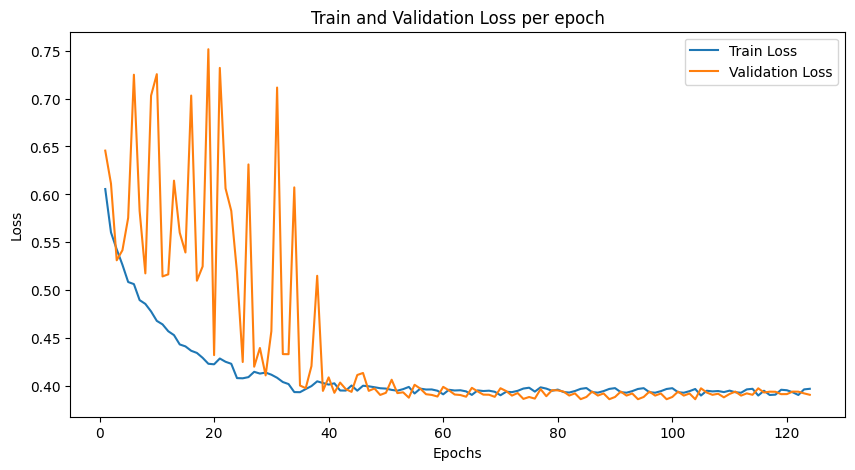

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(track_all_train_loss) + 1), track_all_train_loss, label='Train Loss')
plt.plot(range(1, len(track_all_val_loss) + 1), track_all_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per epoch')
plt.legend()
plt.show()

Testing

In [ ]:
model_weight_path = '/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/Plain_RESNET18/DENOISED_FULL_PSFHSP_12k/fold_model/best_model.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = resnet18.to(device)

net.load_state_dict(torch.load(model_weight_path))
print(net.load_state_dict(torch.load(model_weight_path)))

cpu
<All keys matched successfully>


In [ ]:
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Initialize an array to store filenames
true_negative_filenames = []

net.eval()

true = []
pre = []
proba = []

# DataLoader for the test dataset
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset_f, batch_size=batch_size, shuffle=False, num_workers=0)

# Loop through the test dataset
for batch_idx, (images, labels) in enumerate(test_loader):
    # Get corresponding file paths for the current batch
    batch_image_paths = test_image_paths[batch_idx * batch_size:(batch_idx + 1) * batch_size]

    # Make predictions
    outputs = net(images.to(device))
    preds = outputs.argmax(dim=1, keepdim=True).cpu().numpy()
    test_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()

    # Extend true labels, predictions, and probabilities
    true.extend(labels.cpu().numpy())
    pre.extend(preds)
    proba.extend(test_probs)

    # Save true positive filenames in the array
    for label, pred, img_path in zip(labels, preds, batch_image_paths):
        if label.item() == 1 and pred.item() == 1:
            original_name = os.path.basename(img_path)
            true_negative_filenames.append(original_name)

test_accuracy = accuracy_score(true, pre)
test_f1 = f1_score(true, pre)
test_roc = roc_auc_score(true, proba)
test_precision = precision_score(true, pre)
test_recall = recall_score(true, pre)

print(f"Test Accuracy: {test_accuracy}, Test F1: {test_f1}, Test ROC: {test_roc}, Test Precision: {test_precision}, Test Recall: {test_recall}")

true_negatives = sum((np.array(true) == 1) & (np.array(pre).flatten() == 1))
print(f"True Negatives (Predicted 1 when Ground Truth is 1): {true_negatives}")

# Output the list of true positive filenames
print(f"True negative filenames: {len(true_negative_filenames)}")

Test Accuracy: 0.9303767286599904, Test F1: 0.9509078681909886, Test ROC: 0.9767826699702225, Test Precision: 0.970487302676733, Test Recall: 0.9321028345418589
True Negatives (Predicted 1 when Ground Truth is 1): 1414
True negative filenames: 1414


In [ ]:
# Test Accuracy: 0.9303767286599904, Test F1: 0.9509078681909886, test roc: 0.9767826699702225, test precision: 0.970487302676733, test recall: 0.9321028345418589

In [ ]:
print(true_negative_filenames)

['00476PSFHSAoP4k_476.png', '01347PSFHSAoP4k_1347.png', '03338PSFHSAoP4k_3338.png', '20190916T110257_109.png', '00742PSFHSAoP4k_742.png', '04173PSFHSAoP1358_430.png', '04098PSFHSAoP1358_355.png', '20191127T110323_309.png', '20191129T103133_679.png', '01667PSFHSAoP4k_1667.png', '03055PSFHSAoP4k_3055.png', '04716PSFHSAoP1358_973.png', '20191115T105623_649.png', '03321PSFHSAoP4k_3321.png', '20191003T173034_649.png', '01716PSFHSAoP4k_1716.png', '04321PSFHSAoP1358_578.png', '20191115T105730_369.png', '20200103T102728_179.png', '02391PSFHSAoP4k_2391.png', '05093PSFHSAoP1358_1350.png', '20200103T102623_517.png', '20190918T123437_359.png', '20200103T104919_609.png', '20190909T161453_89.png', '02912PSFHSAoP4k_2912.png', '20190918T123342_1099.png', '20190918T120011_609.png', '20191026T195815_199.png', '04334PSFHSAoP1358_591.png', '20191129T110732_739.png', '01837PSFHSAoP4k_1837.png', '01996PSFHSAoP4k_1996.png', '04624PSFHSAoP1358_881.png', '20200103T104919_649.png', '20191220T113230_409.png', '2

In [ ]:
# import os
# from PIL import Image
# from shutil import copyfile

# # Define a folder to save the original images
# save_folder = "/content/drive/MyDrive/thesis/dataset_6302024/3.Thesis_balanced_12k/TN_images"
# os.makedirs(save_folder, exist_ok=True)
# cnt = 0

# # Save the original images if their filenames align with true_positive_filenames
# for img_path in test_image_paths:
#     original_name = os.path.basename(img_path)  # Extract the filename
#     if original_name in true_negative_filenames:  # Check alignment
#         save_path = os.path.join(save_folder, original_name)  # Destination path
#         copyfile(img_path, save_path)  # Copy the file to the destination
#         cnt += 1
#         print(f"Saved: {original_name} image no {cnt}")

RuntimeError: The size of tensor a (7) must match the size of tensor b (56) at non-singleton dimension 3

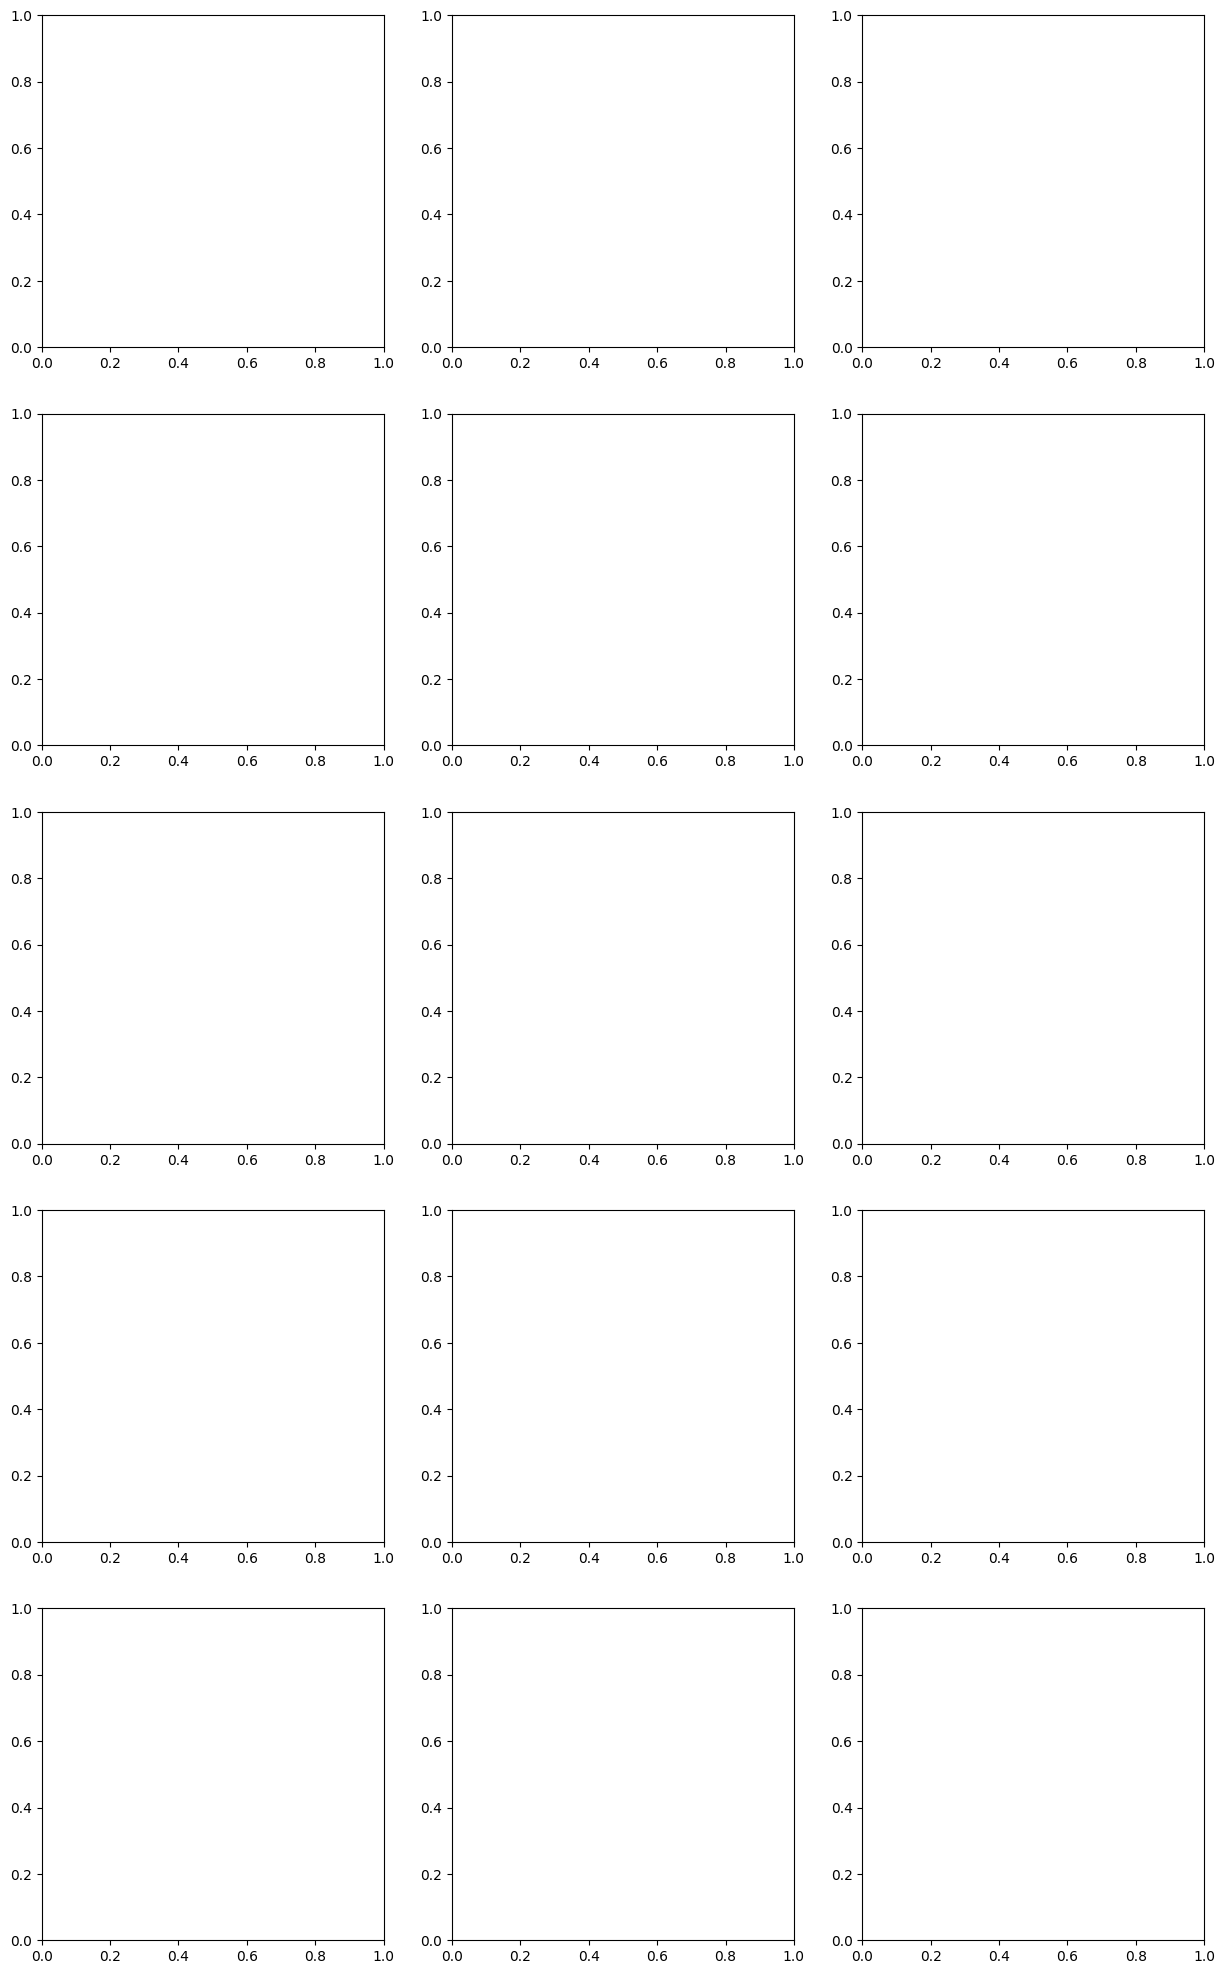

In [ ]:
class LRP:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.intermediate_outputs = {}
        self.register_hooks()

    def register_hooks(self):
        """Register forward hooks to capture intermediate outputs"""
        def hook_function(name):
            def hook(module, input, output):
                self.intermediate_outputs[name] = input[0]
            return hook

        # Register hooks for all relevant layers
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                module.register_forward_hook(hook_function(name))

    def compute_layer_relevance(self, input_tensor, target_class):
        # Clear previous intermediate outputs
        self.intermediate_outputs = {}

        # Forward pass
        input_tensor.requires_grad_()
        output = self.model(input_tensor)

        # Initialize relevance with zeros except for target class
        R = torch.zeros_like(output)
        R[0, target_class] = output[0, target_class]

        relevance = R

        # Backward propagation of relevance through different components
        # Going backwards through the network
        relevance = self._fc_lrp(self.model.fc, relevance)
        relevance = self._avgpool_lrp(self.model.avgpool, relevance)

        # Layer4 to Layer1 (going backwards)
        layers = [self.model.layer4, self.model.layer3, self.model.layer2, self.model.layer1]
        for layer in reversed(layers):
            relevance = self._residual_block_lrp(layer, relevance)

        # Initial layers
        relevance = self._maxpool_lrp(self.model.maxpool, relevance)
        relevance = self._relu_lrp(self.model.relu, relevance)
        relevance = self._bn_lrp(self.model.bn1, relevance)
        relevance = self._conv_lrp(self.model.conv1, relevance)

        return relevance


    def _residual_block_lrp(self, layer, relevance, epsilon=1e-9):
        """LRP for residual blocks"""
        for block in reversed(layer):
            # Handle the residual connection
            identity = relevance.clone()

            # Main path
            relevance = self._bn_lrp(block.bn2, relevance)
            relevance = self._conv_lrp(block.conv2, relevance)
            relevance = self._relu_lrp(block.relu, relevance)
            relevance = self._bn_lrp(block.bn1, relevance)
            relevance = self._conv_lrp(block.conv1, relevance)

            # Identity path
            if block.identity_downsample is not None:
                identity = self._identity_downsample_lrp(block.identity_downsample, identity)

            # Combine paths
            relevance = relevance + identity
            relevance = self._relu_lrp(block.relu, relevance)

        return relevance

    def _conv_lrp(self, layer, relevance, epsilon=1e-9):
        """LRP for convolutional layers"""
        with torch.enable_grad():
            layer_name = [name for name, module in self.model.named_modules() if module is layer][0]
            x = self.intermediate_outputs[layer_name]
            z = layer(x)
            s = (relevance / (z + epsilon)) * z
            c = torch.autograd.grad(z, x, s)[0]
            return x * c

    def _bn_lrp(self, layer, relevance):
        """LRP for batch normalization layers"""
        return relevance  # Pass through for batch norm

    def _relu_lrp(self, layer, relevance):
        """LRP for ReLU layers"""
        return relevance

    def _maxpool_lrp(self, layer, relevance):
        """LRP for max pooling layers"""
        return relevance.repeat_interleave(2, dim=2).repeat_interleave(2, dim=3)

    def _avgpool_lrp(self, layer, relevance):
        """LRP for adaptive average pooling layers"""
        if len(relevance.shape) == 2:
            # If the input is flattened (2D), reshape it to 4D
            batch_size = relevance.shape[0]
            relevance = relevance.view(batch_size, -1, 1, 1)

        # Calculate the scaling factor based on input and output sizes
        input_size = 7  # Size after the last conv layer
        output_size = 1  # Size after adaptive avgpool
        scale_factor = input_size // output_size

        # Repeat the relevance scores
        relevance = relevance.repeat_interleave(scale_factor, dim=2)
        relevance = relevance.repeat_interleave(scale_factor, dim=3)

        return relevance


    def _fc_lrp(self, layer, relevance, epsilon=1e-9):
        """LRP for fully connected layers"""
        with torch.enable_grad():
            layer_name = [name for name, module in self.model.named_modules() if module is layer][0]
            x = self.intermediate_outputs[layer_name]
            z = layer(x)
            s = (relevance / (z + epsilon)) * z
            c = torch.autograd.grad(z, x, s)[0]
            return x * c

    def _identity_downsample_lrp(self, identity_downsample, relevance):
        """LRP for identity downsample path"""
        if identity_downsample is None:
            return relevance

        for layer in reversed(identity_downsample):
            if isinstance(layer, nn.Conv2d):
                relevance = self._conv_lrp(layer, relevance)
            elif isinstance(layer, nn.BatchNorm2d):
                relevance = self._bn_lrp(layer, relevance)
        return relevance

    # def visualize_relevance(self, relevance_map):
    #     """Visualize the relevance map"""
    #     relevance_map = relevance_map.detach().cpu().numpy()
    #     relevance_map = np.sum(np.abs(relevance_map), axis=1)[0]

    #     plt.imshow(relevance_map, cmap='seismic', interpolation='nearest')
    #     plt.colorbar()
    #     plt.show()

    # ... (keep all the existing LRP methods the same)
    # Add a new method for multiple visualizations
    def visualize_multiple_samples(self, dataloader, num_samples=5):
        # Get random indices
        total_samples = len(dataloader.dataset)
        random_indices = random.sample(range(total_samples), num_samples)

        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

        for idx, sample_idx in enumerate(random_indices):
            # Get the sample
            image, label = dataloader.dataset[sample_idx]
            image_path = dataloader.dataset.image_paths[sample_idx]

            # Prepare input
            input_tensor = image.unsqueeze(0).to(next(self.model.parameters()).device)

            # Get model prediction
            with torch.no_grad():
                output = self.model(input_tensor)
                predicted_class = output.argmax(dim=1).item()
                confidence = torch.nn.functional.softmax(output, dim=1)[0][predicted_class].item()

            # Compute relevance map
            relevance_map = self.compute_layer_relevance(input_tensor, predicted_class)

            # Denormalize image for visualization
            img_for_display = self.denormalize_image(image)

            # Plot original image
            axes[idx, 0].imshow(img_for_display.permute(1, 2, 0).cpu().numpy())
            axes[idx, 0].set_title(f'Original Image\nTrue: {label}')
            axes[idx, 0].axis('off')

            # Plot relevance map
            relevance = relevance_map.sum(dim=1)[0].cpu().detach().numpy()
            relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min())
            axes[idx, 1].imshow(relevance, cmap='hot')
            axes[idx, 1].set_title(f'LRP Heatmap\nPred: {predicted_class}')
            axes[idx, 1].axis('off')

            # Plot overlay
            axes[idx, 2].imshow(img_for_display.permute(1, 2, 0).cpu().numpy())
            axes[idx, 2].imshow(relevance, cmap='hot', alpha=0.5)
            axes[idx, 2].set_title(f'Overlay\nConf: {confidence:.2f}')
            axes[idx, 2].axis('off')

            # Print additional information
            print(f"\nSample {idx + 1}:")
            print(f"Image path: {image_path}")
            print(f"True class: {label} ({['Non-standard_plane', 'Standard_plane'][label]})")
            print(f"Predicted class: {predicted_class} ({['Non-standard_plane', 'Standard_plane'][predicted_class]})")
            print(f"Confidence: {confidence:.4f}")

        plt.tight_layout()
        plt.show()

    def denormalize_image(self, image):
        """Denormalize the image for visualization"""
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]

        image = image.clone()
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)

        return image




def visualize_random_samples():

    # Create LRP explainer
    lrp = LRP(net)

    # Visualize multiple random samples
    lrp.visualize_multiple_samples(test_loader, num_samples=5)


visualize_random_samples()

In [ ]:
# def apply_lrp_on_resnet18(model, image):
#     image = torch.unsqueeze(image, 0)

#     # >>> Step 1: Extract layers
#     # Create a list of all layers in sequential order
#     layers = [
#         model.conv1,
#         model.bn1,
#         model.relu,
#         model.maxpool
#     ]

#     # Add all blocks from layer1-4
#     for layer_block in [model.layer1, model.layer2, model.layer3, model.layer4]:
#         for block in layer_block:
#             layers.extend([
#                 block.conv1,
#                 block.bn1,
#                 block.relu,
#                 block.conv2,
#                 block.bn2,
#                 block.relu
#             ])
#             if block.identity_downsample is not None:
#                 layers.extend(list(block.identity_downsample))

#     # Add final layers
#     layers.extend([
#         model.avgpool,
#         model.fc
#     ])

#     # >>> Step 2: Propagate image through layers and store activations
#     n_layers = len(layers)
#     activations = [image] + [None] * n_layers

#     # Forward pass
#     x = image
#     for i, layer in enumerate(layers):
#         if isinstance(layer, nn.BatchNorm2d):
#             # Skip BatchNorm during relevance propagation
#             activations[i+1] = x
#             continue

#         x = layer(x)
#         if isinstance(layer, nn.AdaptiveAvgPool2d):
#             x = torch.flatten(x, start_dim=1)
#         activations[i+1] = x

#     # >>> Step 3: Replace last layer with one-hot-encoding
#     output_activation = activations[-1].detach().cpu().numpy()
#     max_activation = output_activation.max()
#     one_hot_output = [val if val == max_activation else 0
#                       for val in output_activation[0]]
#     activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

#     # >>> Step 4: Backpropagate relevance scores
#     relevances = [None] * n_layers + [activations[-1]]

#     # Iterate over the layers in reverse order
#     for layer in range(0, n_layers)[::-1]:
#         current = layers[layer]

#         # Skip BatchNorm layers
#         if isinstance(current, nn.BatchNorm2d):
#             relevances[layer] = relevances[layer+1]
#             continue

#         # Treat max pooling layers as avg pooling
#         if isinstance(current, nn.MaxPool2d):
#             layers[layer] = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
#             current = layers[layer]

#         if isinstance(current, nn.Conv2d) or \
#            isinstance(current, nn.AvgPool2d) or \
#            isinstance(current, nn.Linear):
#             activations[layer] = activations[layer].data.requires_grad_(True)

#             # Apply LRP rules based on layer depth
#             # Early layers (conv1 and first few blocks)
#             if layer <= 20:
#                 rho = lambda p: p + 0.25*p.clamp(min=0)
#                 incr = lambda z: z+1e-9
#             # Middle layers
#             elif 21 <= layer <= 40:
#                 rho = lambda p: p
#                 incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
#             # Later layers
#             else:
#                 rho = lambda p: p
#                 incr = lambda z: z+1e-9

#             # LRP propagation
#             z = incr(new_layer(layers[layer], rho).forward(activations[layer]))
#             s = (relevances[layer+1]/z).data
#             (z * s).sum().backward()
#             c = activations[layer].grad
#             relevances[layer] = (activations[layer]*c).data
#         else:
#             relevances[layer] = relevances[layer+1]

#     return relevances[0]


import copy

def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try:
        layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError:
        pass
    try:
        layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError:
        pass
    return layer

# Define BlockWithSkip class at the module level
class BlockWithSkip(nn.Module):
    def __init__(self, block_layers, identity_downsample):
        super().__init__()
        self.layers = nn.Sequential(*block_layers)
        self.identity_downsample = identity_downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.layers(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        out += identity
        return self.relu(out)

def apply_lrp_on_resnet18(model, image):
    image = torch.unsqueeze(image, 0)

    # >>> Step 1: Extract layers and create a sequential model
    layers = []

    # Initial layers
    layers.extend([
        model.conv1,
        model.bn1,
        model.relu,
        model.maxpool
    ])

    # Function to add block layers
    def add_block_layers(block):
        block_layers = [
            block.conv1,
            block.bn1,
            block.relu,
            block.conv2,
            block.bn2
        ]
        return BlockWithSkip(block_layers, block.identity_downsample)

    # Add all blocks
    for layer_block in [model.layer1, model.layer2, model.layer3, model.layer4]:
        for block in layer_block:
            layers.append(add_block_layers(block))

    # Final layers
    layers.extend([
        model.avgpool,
        model.fc
    ])

    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers

    # Forward pass
    x = image
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.BatchNorm2d):
            activations[i+1] = x
            continue

        if isinstance(layer, nn.AdaptiveAvgPool2d):
            x = layer(x)
            activations[i+1] = x
            continue

        if isinstance(layer, nn.Linear):
            x = x.view(x.size(0), -1)

        x = layer(x)
        activations[i+1] = x

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach()
    max_idx = output_activation.argmax(dim=1)
    one_hot_output = torch.zeros_like(output_activation)
    one_hot_output[0, max_idx] = 1.0
    activations[-1] = one_hot_output

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]

    for layer in range(n_layers-1, -1, -1):
        current = layers[layer]

        if isinstance(current, nn.BatchNorm2d):
            relevances[layer] = relevances[layer+1]
            continue

        if isinstance(current, nn.MaxPool2d):
            layers[layer] = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            current = layers[layer]

        if isinstance(current, (nn.Conv2d, nn.AvgPool2d, nn.Linear, BlockWithSkip)):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply LRP rules based on layer depth
            if layer <= 4:  # Initial layers
                rho = lambda p: p + 0.25*p.clamp(min=0)
                incr = lambda z: z+1e-9
            elif layer <= 12:  # Middle layers
                rho = lambda p: p
                incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            else:  # Later layers
                rho = lambda p: p
                incr = lambda z: z+1e-9

            try:
                # Handle transitions between different layer types
                if isinstance(current, nn.Linear):
                    if len(activations[layer].shape) > 2:
                        activations[layer] = activations[layer].view(activations[layer].size(0), -1)
                    z = incr(new_layer(current, rho).forward(activations[layer]))

                    if len(relevances[layer+1].shape) > 2:
                        relevances[layer+1] = relevances[layer+1].view(relevances[layer+1].size(0), -1)

                elif isinstance(current, nn.AdaptiveAvgPool2d):
                    z = incr(current(activations[layer]))
                    if len(relevances[layer+1].shape) == 2:
                        n, c = activations[layer].shape[:2]
                        relevances[layer+1] = relevances[layer+1].view(n, c, 1, 1)

                elif isinstance(current, BlockWithSkip):
                    z = incr(current(activations[layer]))
                    if len(relevances[layer+1].shape) == 2:
                        n, c = z.shape[:2]
                        h = w = int((relevances[layer+1].size(1) // c) ** 0.5)
                        relevances[layer+1] = relevances[layer+1].view(n, c, h, w)
                else:
                    z = incr(new_layer(current, rho).forward(activations[layer]))

                # Ensure shapes match
                if z.shape != relevances[layer+1].shape:
                    if len(z.shape) == 4 and len(relevances[layer+1].shape) == 4:
                        relevances[layer+1] = nn.functional.interpolate(
                            relevances[layer+1],
                            size=(z.shape[2], z.shape[3]),
                            mode='bilinear',
                            align_corners=False
                        )

                s = (relevances[layer+1]/z).data
                (z * s).sum().backward()

                # Handle None gradients
                if activations[layer].grad is None:
                    relevances[layer] = torch.zeros_like(activations[layer])
                else:
                    c = activations[layer].grad
                    relevances[layer] = (activations[layer]*c).data

            except Exception as e:
                print(f"Error at layer {layer}: {str(e)}")
                relevances[layer] = torch.zeros_like(activations[layer])

        else:
            relevances[layer] = relevances[layer+1]

    return relevances[0]



# Define class names separately
CLASS_NAMES = ['Non-standard_plane', 'Standard_plane']

def get_class_name(idx):
    return CLASS_NAMES[idx]

# Display 5 random images
plt.figure(figsize=(15, 25))
for i in range(5):
    input_image, label = random.choice(test_dataset_f)
    input_image = input_image.to(device)

    with torch.no_grad():
        output = resnet18(input_image.unsqueeze(0))
        pred = output.argmax(dim=1).item()

    image_relevances = apply_lrp_on_resnet18(resnet18, input_image)
    print(image_relevances)
    image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
    image_relevances = np.interp(image_relevances,
                                (image_relevances.min(), image_relevances.max()),
                                (0, 1))

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(image_relevances[:,:,0], cmap="seismic")
    plt.title('Relevance Map')
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    # Denormalize the input image
    input_img_np = input_image.permute(1,2,0).cpu().numpy()
    input_img_np = input_img_np * 0.5 + 0.5  # Denormalize
    input_img_np = np.clip(input_img_np, 0, 1)  # Ensure values are in [0,1]
    plt.imshow(input_img_np)

    true_class = get_class_name(label)
    pred_class = get_class_name(pred)

    correct = pred == label
    title = f'True: {true_class}\nPred: {pred_class}\n{"✓" if correct else "✗"}'
    plt.title(title, color='green' if correct else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true, pre)

# Plot the confusion matrix
class_labels = ['Non-standard_plane','Standard_plane']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Confidence Interval

In [ ]:
# using traditonal method to calculate CI

# Import necessary libraries
import numpy as np
from scipy import stats

# Function to calculate 95% confidence interval for a parameter x
def calculate_confidence_interval(x, sample_size, confidence_level=0.95):
    # Calculate the standard error
    standard_error = np.sqrt((x * (1 - x)) / sample_size)

    # Find the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_score * standard_error

    # Calculate the confidence interval
    lower_bound = x - margin_of_error
    upper_bound = x + margin_of_error

    return lower_bound, upper_bound

ci_lower, ci_upper = calculate_confidence_interval(test_accuracy, len(test_loader.dataset), confidence_level=0.95)
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Confidence Interval: (0.9195, 0.9413)


In [ ]:
# Bootstrapping AUCs to calculate CI

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_auc(y_test, y_pred, n_iterations=2000, confidence_level=0.95):
    # Store the AUCs
    aucs = []
    n_size = len(y_test)

    for i in range(n_iterations):
        # print("Processing: ",i)
        # Resample the data with replacement
        y_test_resampled, y_pred_resampled = resample(y_test, y_pred, n_samples=n_size)
        # Calculate the AUC
        auc = roc_auc_score(y_test_resampled, y_pred_resampled)
        aucs.append(auc)

    # Calculate the lower and upper percentiles for the confidence interval
    lower_bound = np.percentile(aucs, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(aucs, (confidence_level + ((1 - confidence_level) / 2)) * 100)

    return lower_bound, upper_bound, aucs


lower_ci, upper_ci, auc_scores = bootstrap_auc(true, pre)
print(f"Bootstrap AUC 95% CI: ({lower_ci:.3f}, {upper_ci:.3f})")

Bootstrap AUC 95% CI: (0.917, 0.941)


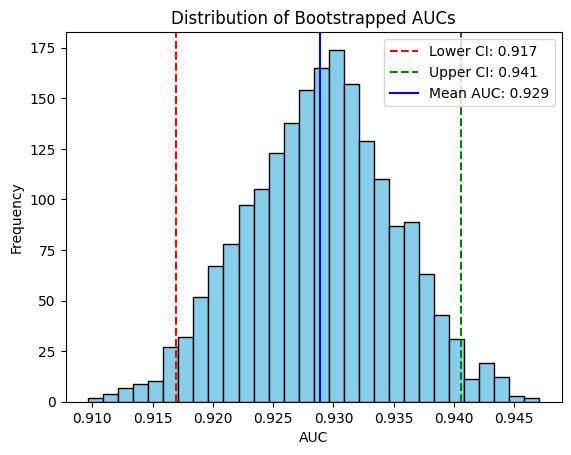

In [ ]:
import matplotlib.pyplot as plt

plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Bootstrapped AUCs')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.axvline(lower_ci, color='red', linestyle='--', label=f'Lower CI: {lower_ci:.3f}')
plt.axvline(upper_ci, color='green', linestyle='--', label=f'Upper CI: {upper_ci:.3f}')
plt.axvline(np.mean(auc_scores), color='blue', linestyle='-', label=f'Mean AUC: {np.mean(auc_scores):.3f}')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_auc(y_test, y_pred, n_iterations=2000, confidence_level=0.95):
    """
    Bootstraps AUCs to calculate confidence intervals with stratification.

    Parameters:
    y_test: np.array or list
        True labels (binary classification).
    y_pred: np.array or list
        Predicted probabilities or scores.
    n_iterations: int
        Number of bootstrap iterations.
    confidence_level: float
        Confidence level for the CI.

    Returns:
    lower_bound: float
        Lower bound of the confidence interval.
    upper_bound: float
        Upper bound of the confidence interval.
    aucs: list
        List of AUCs from bootstrapping.
    """
    # Store the AUCs
    aucs = []
    n_size = len(y_test)

    for i in range(n_iterations):
        # Resample the data with replacement, ensuring at least one positive and one negative sample
        while True:
            y_test_resampled, y_pred_resampled = resample(y_test, y_pred, n_samples=n_size)
            if len(np.unique(y_test_resampled)) == 2:  # Check for both classes
                break

        # Calculate the AUC
        auc = roc_auc_score(y_test_resampled, y_pred_resampled)
        aucs.append(auc)

    # Calculate the lower and upper percentiles for the confidence interval
    lower_bound = np.percentile(aucs, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(aucs, (confidence_level + ((1 - confidence_level) / 2)) * 100)

    return lower_bound, upper_bound, aucs

# Example usage:
# Replace true and pre with your actual data
# true = np.array([...])  # Binary ground truth
# pre = np.array([...])   # Predicted probabilities or scores

lower_ci, upper_ci, auc_scores = bootstrap_auc(true, pre)
print(f"Bootstrap AUC 95% CI: ({lower_ci:.3f}, {upper_ci:.3f})")

Bootstrap AUC 95% CI: (0.916, 0.942)
